<a href="https://colab.research.google.com/github/aritejhg/ESP3201-Instrument-indentification/blob/main/data_preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook process the data from MedleyDB and OpenMIC to create a pipeline and transform the audio streams into audio-visual representations such as Log-Mel. 

OneDrive is used to store datasets pre and post processing.

Workflow:

wget zip --> process dataset --> convert back to zip file --> store in gdrive




In [ ]:
# Common commands
!zip -r '/content/folder/"NewFileName.zip"' '/content/folder/"OrginalFileName"'
!unzip <filepath>
!wget <url>
%cp <zip_to_copy> /content/drive/MyDrive/ESP3201/Datasets/<dataset name>

## How processing works
transform (short time fft/ fourier/ constant q) --> spectogram (mel/gamma) --> (maybe) log scale

Extracting mel spectogram 
https://www.youtube.com/watch?v=TdnVE5m3o_0

1. Should we convert to mel-spectogram while importing for training? not sure

  maybe doing it as a form of pre-processing is more efficient

2. What other pre-processing steps need to be taken?

  Maybe data augmentation/weighting to adjust for the class imbalance?

#IRMAS

In [ ]:
# Download dataset
!wget https://zenodo.org/record/1290750/files/IRMAS-TrainingData.zip?download=1

--2022-10-09 03:57:08--  https://zenodo.org/record/1290750/files/IRMAS-TrainingData.zip?download=1
Resolving zenodo.org (zenodo.org)... 188.184.117.155
Connecting to zenodo.org (zenodo.org)|188.184.117.155|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3181049879 (3.0G) [application/octet-stream]
Saving to: ‘IRMAS-TrainingData.zip?download=1’

IRMAS-TrainingData. 100%[===================>]   2.96G  26.2MB/s    in 1m 57s  

2022-10-09 03:59:07 (25.9 MB/s) - ‘IRMAS-TrainingData.zip?download=1’ saved [3181049879/3181049879]



#MedleyDB

#PureMIC 
In case medleydb dun come thru

In [ ]:
# Download the zip file
!wget ftp://193.136.94.104/PureMicDB/paper_files.7z

--2022-10-08 08:52:55--  ftp://193.136.94.104/PureMicDB/paper_files.7z
           => ‘paper_files.7z’
Connecting to 193.136.94.104:21... failed: Connection refused.


In [ ]:
# Extracting the PureMic Dataset
!tar --extract --file /content/PureMicDB/paper_files.7z
!rm /content/PureMicDB/paper_files.7z

#OpenMIC

In [ ]:
# Download original zip
!wget https://zenodo.org/record/1432913/files/openmic-2018-v1.0.0.tgz

--2022-10-08 04:08:45--  https://zenodo.org/record/1432913/files/openmic-2018-v1.0.0.tgz
Resolving zenodo.org (zenodo.org)... 188.184.117.155
Connecting to zenodo.org (zenodo.org)|188.184.117.155|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2623376754 (2.4G) [application/octet-stream]
Saving to: ‘openmic-2018-v1.0.0.tgz’

openmic-2018-v1.0.0 100%[===================>]   2.44G  29.1MB/s    in 92s     

2022-10-08 04:10:19 (27.3 MB/s) - ‘openmic-2018-v1.0.0.tgz’ saved [2623376754/2623376754]



In [ ]:
# no need to copy zip to drive anymore since download is fast
# %cp "/content/openmic-2018-v1.0.0.tgz" "/content/drive/MyDrive/ESP3201/Datasets/openmic-2018-v1.0.0.tgz"

In [ ]:
# Extract and delete the zip
!tar --extract --file /content/openmic-2018-v1.0.0.tgz
!rm /content/openmic-2018-v1.0.0.tgz

# Convert to log mel


In [ ]:
import librosa
import librosa.display
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
files = ['/content/openmic-2018/audio/000/000046_3840.ogg'] # we can make a list comprehension of all files needed
save_path = "/content/log_mel_OpenMIC/"
for file in files:
  scale, sampling_rate = librosa.load(file)
  # filter_banks = librosa.filters.mel(n_fft=2048, sr=22050, n_mels=10)
  mel_spectrogram = librosa.feature.melspectrogram(scale, sr=sampling_rate, n_fft=2048, hop_length=512, n_mels=10)
  log_mel_spectrogram = librosa.power_to_db(mel_spectrogram)
  # print(log_mel_spectrogram.shape)
  # print(type(log_mel_spectrogram))
  np.save((save_path + file.split('/')[-1]).replace(".ogg",''), log_mel_spectrogram)
  # CURRENTLY saves with just filename without the 000 folder structure as the
  # first 3 numbers of filename indicate the folder anyw


  

/content


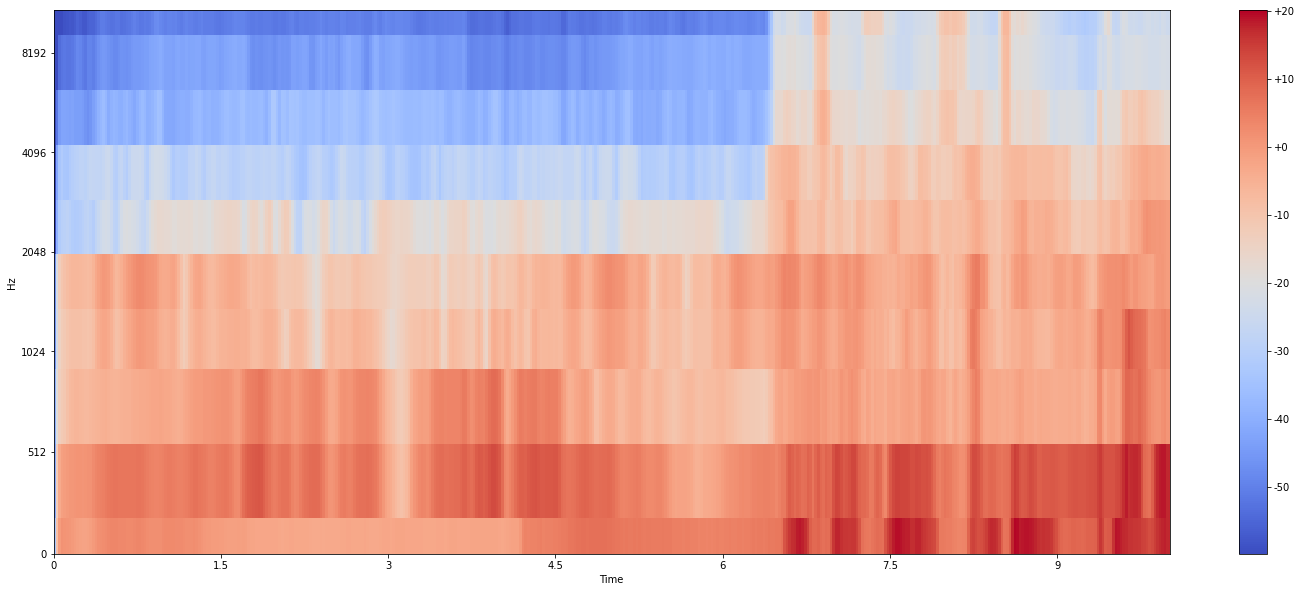

In [ ]:
# For plotting
plt.figure(figsize=(25, 10))
librosa.display.specshow(log_mel_spectrogram, 
                         x_axis="time",
                         y_axis="mel", 
                         sr=sampling_rate)
plt.colorbar(format="%+2.f")
plt.show()


#Convert to gammatone


In [ ]:
!pip install git+https://github.com/detly/gammatone.git


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/detly/gammatone.git to /tmp/pip-req-build-s45bvlau
  Running command git clone -q https://github.com/detly/gammatone.git /tmp/pip-req-build-s45bvlau
     |████████████████████████████████| 154 kB 32.5 MB/s 
  Created wheel for Gammatone: filename=Gammatone-1.0-py3-none-any.whl size=21795 sha256=92b59f197ac27303a9a58b198778a0fe9ab152bfbaa5a8527ceb342cce12c823
  Stored in directory: /tmp/pip-ephem-wheel-cache-bq31qtb2/wheels/07/b9/a7/356576d1172ea99bf71c5f5502bb20e951769a34b4e86fe6cc
Successfully built Gammatone


In [ ]:
!gammatone /content/000046_3840.wav -d 10

Figure(640x480)


In [ ]:
import scipy.io.wavfile
samplerate, data = scipy.io.wavfile.read('/content/000046_3840.wav')
print(data)

[[    0     0]
 [    0     0]
 [    0     0]
 ...
 [-3068 -7416]
 [-3294 -7726]
 [-3015 -7698]]


In [ ]:
scale, sampling_rate = librosa.load('/content/openmic-2018/audio/000/000046_3840.ogg')
print(scale)

[ 0.          0.          0.         ... -0.15737659 -0.15117157
 -0.1723783 ]
